In [ ]:
import subprocess
import time
# Step 1: Run powermetrics to collect power data
# Define log files
power_log_file = "power_log.txt"
error_log_file = "error_log.txt"

print("Collecting power metrics... (type for ~10-20 seconds, then stop)")
sudo_password = "YOURPASSWORD"
try:
    with open(power_log_file, "w") as f, open(error_log_file, "w") as err_f:
        process = subprocess.Popen(
            ["sudo", "-S", "powermetrics", "--samplers", "cpu_power", "-i", "10"],
            stdin=subprocess.PIPE, stdout=f, stderr=err_f, text=True
        )
        
        # Pass the sudo password
        process.stdin.write(sudo_password + "\n")
        process.stdin.flush()
        
        time.sleep(60)  # Record for 20 seconds
        process.terminate()  # Stop powermetrics
    print("Power data collection complete.")
    print(f"Any errors were logged to {error_log_file}")

except KeyboardInterrupt:
    process.terminate()
    print("Stopped data collection early.")

Stopped data collection early.


In [2]:
# Step 2: Extract CPU power data using grep
extracted_file = "extracted_data.txt"
subprocess.run(f"grep 'CPU Power' {power_log_file} > {extracted_file}", shell=True)
print("Extracted CPU power data.")

Extracted CPU power data.


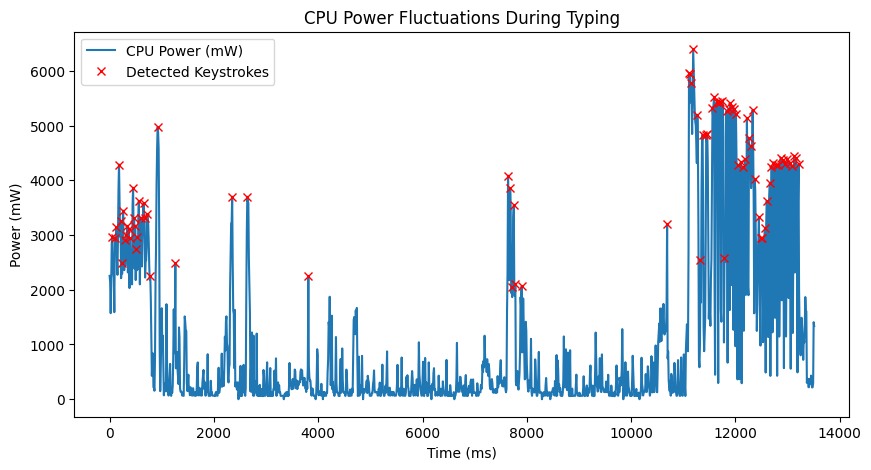

Estimated number of keystrokes: 85


In [3]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Step 3: Load and analyze power data
times = []
power_values = []

with open(extracted_file, "r") as f:
    for i, line in enumerate(f):
        try:
            power = float(line.split(":")[-1].strip().split()[0])
            times.append(i * 10)  # Assuming 10ms intervals
            power_values.append(power)
        except:
            continue

# Convert to NumPy array
times = np.array(times)
power_values = np.array(power_values)

# Step 4: Detect peaks (potential keystrokes)
from scipy.signal import find_peaks

# Define constraints
min_time_between_keystrokes = 20  # in milliseconds
max_power_threshold = np.mean(power_values) + 4 * np.std(power_values)  # Ignore extreme spikes

# Detect peaks with height threshold
peaks, properties = find_peaks(
    power_values, 
    height=np.mean(power_values) + 0.7 * np.std(power_values),  # Keystroke sensitivity
    distance=min_time_between_keystrokes / 10  # Convert ms to index (assuming 10ms intervals)
)

# Filter out peaks that exceed max power threshold
filtered_peaks = [p for p in peaks if power_values[p] < max_power_threshold]
filtered_peaks = np.array(filtered_peaks)

# Plot results
plt.figure(figsize=(10,5))
plt.plot(times, power_values, label="CPU Power (mW)")
plt.plot(times[filtered_peaks], power_values[filtered_peaks], "rx", label="Detected Keystrokes")
plt.xlabel("Time (ms)")
plt.ylabel("Power (mW)")
plt.title("CPU Power Fluctuations During Typing")
plt.legend()
plt.show()

print(f"Estimated number of keystrokes: {len(filtered_peaks)}")



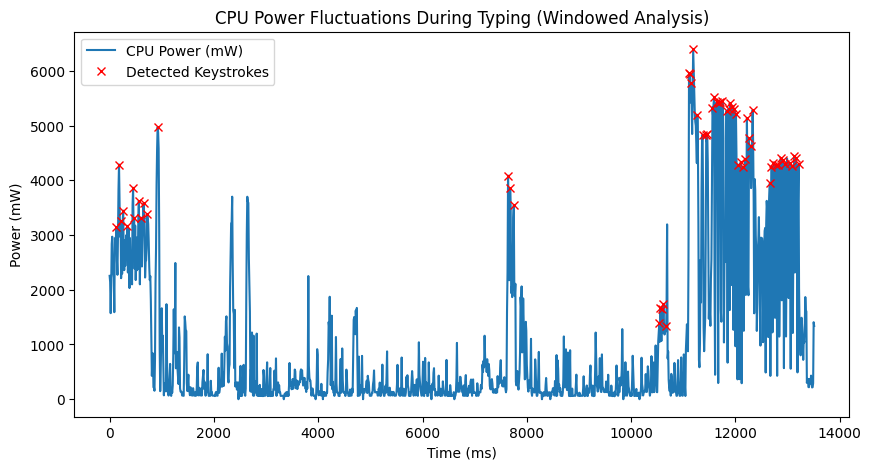

Estimated number of keystrokes: 61


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Load power data
times = []
power_values = []

with open(extracted_file, "r") as f:
    for i, line in enumerate(f):
        try:
            power = float(line.split(":")[-1].strip().split()[0])
            times.append(i * 10)  # Assuming 10ms intervals
            power_values.append(power)
        except:
            continue

# Convert to NumPy arrays
times = np.array(times)
power_values = np.array(power_values)

# Define window size (e.g., 500ms)
window_size_ms = 500
window_size = window_size_ms // 10  # Convert to number of data points

# Keystroke detection constraints
min_time_between_keystrokes = 20  # Minimum time between keystrokes (ms)

# Store detected peaks
filtered_peaks = []

past_window_means = []

# Process data in windows
for start in range(0, len(power_values), window_size):
    end = min(start + window_size, len(power_values))
    segment = power_values[start:end]

    if len(segment) < 10:  # Ignore very short segments
        continue

    # Compute dynamic thresholds for this window
    segment_mean = np.mean(segment)
    segment_std = np.std(segment)
    max_power_threshold = segment_mean + 3 * segment_std  # Ignore extreme spikes
  #  if segment_mean < 700:
   #     continue
    # Detect peaks for this segment 
    # Calculate mean power of the current window
    current_window_mean = np.mean(power_values[start:start + window_size])

    # Ignore if it's too small compared to the rolling past mean
    if past_window_means and current_window_mean < 0.3 * np.mean(past_window_means[-5:]):
        continue  # Skip this window entirely

    # Update rolling window history (limit to last 5 windows for smoothing)
    past_window_means.append(current_window_mean)
    if len(past_window_means) > 5:
        past_window_means.pop(0)


    peaks, _ = find_peaks(
        segment,
        height=segment_mean + 0.7 * segment_std,  # Adaptive sensitivity per window
        distance=min_time_between_keystrokes / 10  # Convert ms to index
    )

    # Filter peaks exceeding threshold
    peaks = np.array([p for p in peaks if segment[p] < max_power_threshold])

    # Store peaks with correct indexing
    filtered_peaks.extend(peaks + start)

filtered_peaks = np.array(filtered_peaks)

# Plot results
plt.figure(figsize=(10,5))
plt.plot(times, power_values, label="CPU Power (mW)")
plt.plot(times[filtered_peaks], power_values[filtered_peaks], "rx", label="Detected Keystrokes")
plt.xlabel("Time (ms)")
plt.ylabel("Power (mW)")
plt.title("CPU Power Fluctuations During Typing (Windowed Analysis)")
plt.legend()
plt.show()

print(f"Estimated number of keystrokes: {len(filtered_peaks)}")
